In [1]:
pip install transformers scikit-learn pandas torch matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\johnd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Import necessary packages
import os
from sklearn.model_selection import train_test_split
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# %% 
# Define a function to load and preprocess the dataset
def preprocess_dataset(file_path):
    df = pd.read_csv(file_path)

    print(f"Processing file: {file_path}")
    print("Columns in the DataFrame:", df.columns)

    sentiment_column_name = 'sentiment'  # Ensure this is the correct column name in your dataset
    if sentiment_column_name not in df.columns:
        print(f"Column '{sentiment_column_name}' not found in {file_path}.")
        return None

    # Map sentiment labels using the defined mapping
    standard_label_mapping = {
        2: "positive",
        "Positive": "positive",
        "positive": "positive",
        "good": "positive",
        "excellent": "positive",
        "neutral": "neutral",
        "Neutral": "neutral",
        "okay": "neutral",
        "negative": "negative",
        1: "negative",
        "Negative": "negative",
        "bad": "negative",
        "poor": "negative"
    }

    df['sentiment'] = df[sentiment_column_name].map(standard_label_mapping)
    df['sentiment'] = df['sentiment'].fillna("neutral")

    label_mapping = {
        "negative": 0,
        "neutral": 1,
        "positive": 2
    }
    df['label'] = df['sentiment'].map(label_mapping)

    # Return the processed dataframe
    return df

In [4]:
# Load and preprocess the data
file_paths = [
    "dataset/feedback_tagalog2.csv",
    "dataset/feedback_tagalog.csv",
    "dataset/service_feedback_tagalog.csv"
]
processed_datasets = [preprocess_dataset(fp) for fp in file_paths]
combined_df = pd.concat(processed_datasets, ignore_index=True)

print(f"Number of records in 'feedback_tagalog2.csv': {processed_datasets[0].shape[0]}")
print(f"Number of records in 'feedback_tagalog.csv': {processed_datasets[1].shape[0]}")
print(f"Number of records in 'service_feedback_tagalog.csv': {processed_datasets[2].shape[0]}")
print(f"Total number of records in the combined dataset: {combined_df.shape[0]}")


Processing file: dataset/feedback_tagalog2.csv
Columns in the DataFrame: Index(['feedback', 'sentiment'], dtype='object')
Processing file: dataset/feedback_tagalog.csv
Columns in the DataFrame: Index(['feedback', 'sentiment'], dtype='object')
Processing file: dataset/service_feedback_tagalog.csv
Columns in the DataFrame: Index(['feedback', 'sentiment'], dtype='object')
Number of records in 'feedback_tagalog2.csv': 3000
Number of records in 'feedback_tagalog.csv': 3000
Number of records in 'service_feedback_tagalog.csv': 3000
Total number of records in the combined dataset: 9000


In [5]:
output_dir = './data_test'
train_path = os.path.join(output_dir, 'train')
val_path = os.path.join(output_dir, 'val')
test_path = os.path.join(output_dir, 'test')

In [6]:
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

In [7]:
# Splitting the data into 80% train, 10% validation, and 10% test
train_df, temp_df = train_test_split(combined_df, test_size=0.2, random_state=42, stratify=combined_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])


In [8]:
# Save each split as a CSV file in its respective directory
train_df.to_csv(os.path.join(train_path, 'train.csv'), index=False)
val_df.to_csv(os.path.join(val_path, 'val.csv'), index=False)
test_df.to_csv(os.path.join(test_path, 'test.csv'), index=False)

In [9]:
# %% 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [10]:
# Tokenization function
def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

In [11]:
# Tokenize and create datasets
def create_dataset(dataframe):
    encodings = tokenize_data(dataframe['feedback'].tolist())
    labels = torch.tensor(dataframe['label'].values)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)
test_dataset = create_dataset(test_df)

In [12]:
# %% 
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:
# Evaluation function to calculate loss and accuracy
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy   

In [14]:
# Training function to store loss and accuracy
def train_model(model, train_loader, val_loader, num_epochs=20):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_epochs * len(train_loader))

    train_losses = []
    val_losses = []
    val_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        # Record training loss
        train_losses.append(total_loss / len(train_loader))

        # Validation after each epoch
        val_loss, val_accuracy = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
    
    # Visualization of Loss and Accuracy
    visualize_results(train_losses, val_losses, val_accuracies)

In [15]:
# Visualization of training/validation loss and accuracy
def visualize_results(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(epochs), y=val_accuracies, palette='viridis')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()



C:\Users\johnd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/20: 100%|██████████| 450/450 [32:04<00:00,  4.28s/it]    


Epoch 1/20, Train Loss: 0.10691766020751352, Val Loss: 0.0003666317400832971, Val Accuracy: 1.0


Epoch 2/20: 100%|██████████| 450/450 [11:56<00:00,  1.59s/it]


Epoch 2/20, Train Loss: 0.00022899211369804107, Val Loss: 0.0001524596821247159, Val Accuracy: 1.0


Epoch 3/20: 100%|██████████| 450/450 [11:52<00:00,  1.58s/it]


Epoch 3/20, Train Loss: 0.00011737851684706078, Val Loss: 9.137158447533453e-05, Val Accuracy: 1.0


Epoch 4/20: 100%|██████████| 450/450 [11:46<00:00,  1.57s/it]


Epoch 4/20, Train Loss: 7.528490244617892e-05, Val Loss: 6.241908091684117e-05, Val Accuracy: 1.0


Epoch 5/20: 100%|██████████| 450/450 [11:46<00:00,  1.57s/it]


Epoch 5/20, Train Loss: 5.335732293638608e-05, Val Loss: 4.582306696408379e-05, Val Accuracy: 1.0


Epoch 6/20: 100%|██████████| 450/450 [11:46<00:00,  1.57s/it]


Epoch 6/20, Train Loss: 4.008008967907194e-05, Val Loss: 3.518894925691073e-05, Val Accuracy: 1.0


Epoch 7/20: 100%|██████████| 450/450 [11:48<00:00,  1.58s/it]


Epoch 7/20, Train Loss: 3.128154828219623e-05, Val Loss: 2.7895342913995447e-05, Val Accuracy: 1.0


Epoch 8/20: 100%|██████████| 450/450 [11:59<00:00,  1.60s/it]


Epoch 8/20, Train Loss: 2.5092706451283045e-05, Val Loss: 2.2642696006969026e-05, Val Accuracy: 1.0


Epoch 9/20: 100%|██████████| 450/450 [12:20<00:00,  1.65s/it]


Epoch 9/20, Train Loss: 2.0553096546791494e-05, Val Loss: 1.8710968409626123e-05, Val Accuracy: 1.0


Epoch 10/20: 100%|██████████| 450/450 [11:09<00:00,  1.49s/it]


Epoch 10/20, Train Loss: 1.7119259799882355e-05, Val Loss: 1.5699812026644378e-05, Val Accuracy: 1.0


Epoch 11/20: 100%|██████████| 450/450 [11:51<00:00,  1.58s/it]


Epoch 11/20, Train Loss: 1.4463702231700557e-05, Val Loss: 1.3355791675725445e-05, Val Accuracy: 1.0


Epoch 12/20: 100%|██████████| 450/450 [12:15<00:00,  1.63s/it]


Epoch 12/20, Train Loss: 1.2372602331096358e-05, Val Loss: 1.1493431597237328e-05, Val Accuracy: 1.0


Epoch 13/20: 100%|██████████| 450/450 [12:37<00:00,  1.68s/it]


Epoch 13/20, Train Loss: 1.0707500851923316e-05, Val Loss: 1.0009475964149092e-05, Val Accuracy: 1.0


Epoch 14/20: 100%|██████████| 450/450 [11:25<00:00,  1.52s/it]


Epoch 14/20, Train Loss: 9.372072735358314e-06, Val Loss: 8.804192962168344e-06, Val Accuracy: 1.0


Epoch 15/20: 100%|██████████| 450/450 [10:54<00:00,  1.45s/it]


Epoch 15/20, Train Loss: 8.299646091877044e-06, Val Loss: 7.8510501177669e-06, Val Accuracy: 1.0


Epoch 16/20: 100%|██████████| 450/450 [10:52<00:00,  1.45s/it]


Epoch 16/20, Train Loss: 7.44091584541214e-06, Val Loss: 7.078417694541267e-06, Val Accuracy: 1.0


Epoch 17/20: 100%|██████████| 450/450 [10:52<00:00,  1.45s/it]


Epoch 17/20, Train Loss: 6.76500423853415e-06, Val Loss: 6.487734537043715e-06, Val Accuracy: 1.0


Epoch 18/20: 100%|██████████| 450/450 [10:48<00:00,  1.44s/it]


Epoch 18/20, Train Loss: 6.25272188699455e-06, Val Loss: 6.053773504071726e-06, Val Accuracy: 1.0


Epoch 19/20: 100%|██████████| 450/450 [10:54<00:00,  1.45s/it]


Epoch 19/20, Train Loss: 5.894384678160552e-06, Val Loss: 5.772222314255104e-06, Val Accuracy: 1.0


Epoch 20/20: 100%|██████████| 450/450 [10:54<00:00,  1.45s/it]


Epoch 20/20, Train Loss: 5.69860142402629e-06, Val Loss: 5.674581101183114e-06, Val Accuracy: 1.0


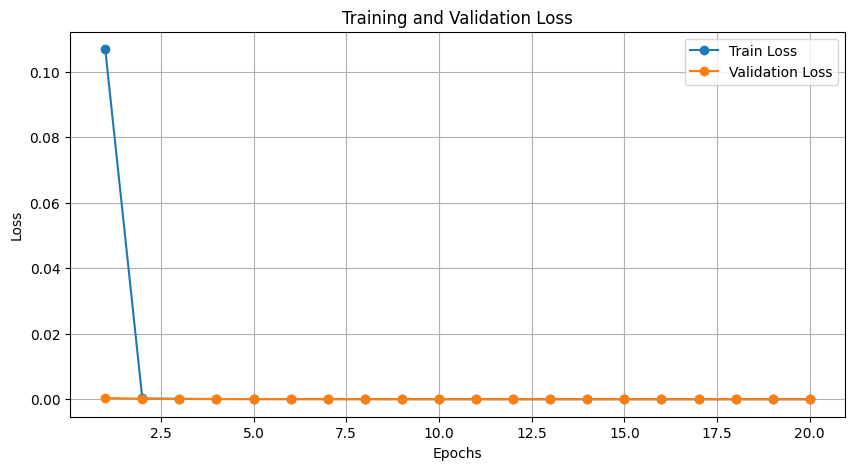

C:\Users\johnd\AppData\Local\Temp\ipykernel_6312\2789118923.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(epochs), y=val_accuracies, palette='viridis')


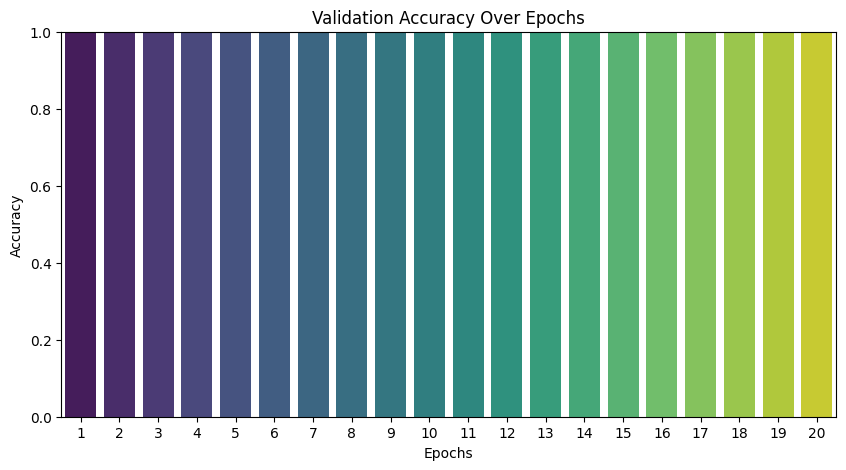

Test Loss: 5.686214368133254e-06, Test Accuracy: 1.0


C:\Users\johnd\AppData\Local\Temp\ipykernel_6312\2387763588.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Test'], y=[test_accuracy], palette='muted')


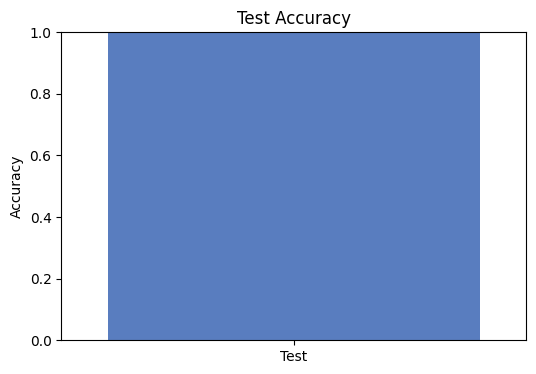

In [16]:
# Train the model and visualize results
train_model(model, train_loader, val_loader, num_epochs=20)

# Final Test Evaluation and Visualization
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Test Accuracy Visualization
plt.figure(figsize=(6, 4))
sns.barplot(x=['Test'], y=[test_accuracy], palette='muted')
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


In [17]:
# Save model and tokenizer
model.save_pretrained('./model/taglish')
tokenizer.save_pretrained('./model/taglish')

('./model/taglish\\tokenizer_config.json',
 './model/taglish\\special_tokens_map.json',
 './model/taglish\\vocab.json',
 './model/taglish\\merges.txt',
 './model/taglish\\added_tokens.json',
 './model/taglish\\tokenizer.json')